In [1]:
#from transformers import BertTokenizer, BertForSequenceClassification
from transformers import XLNetTokenizer, XLNetForSequenceClassification
#from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
torch.manual_seed(1)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

tokenizer = XLNetTokenizer.from_pretrained('textattack/xlnet-base-cased-SST-2')
model = XLNetForSequenceClassification.from_pretrained('textattack/xlnet-base-cased-SST-2').to(device)
#model = BertForSequenceClassification.from_pretrained('textattack/xlnet-base-cased-SST-2',num_labels=3).to(device)
#tokenizer = BertTokenizer.from_pretrained('textattack/xlnet-base-cased-SST-2')
#model = BertForSequenceClassification.from_pretrained('Sigma/financial-sentiment-analysis',num_labels=3).to(device)
#tokenizer = BertTokenizer.from_pretrained('Sigma/financial-sentiment-analysis')
#tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
#model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english').to(device)

2022-05-31 14:26:47.895812: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
device

'cuda:0'

In [3]:
sentences = ["there is a shortage of capital, and we need extra financing",  
             "growth is strong and we have plenty of liquidity", 
             "there are doubts about our finances", 
             "profits are flat"]

inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(device)
model(**inputs)

XLNetForSequenceClassificationOutput(loss=None, logits=tensor([[ 2.1215, -2.6251],
        [-4.2246,  3.4429],
        [ 3.2501, -3.1434],
        [ 1.8369, -2.2899]], device='cuda:0', grad_fn=<AddmmBackward0>), mems=(tensor([[[ 0.0457, -0.0304,  0.0281,  ..., -0.0050,  0.0166, -0.0139],
         [ 0.0344,  0.0202,  0.0261,  ..., -0.0175, -0.0343,  0.0252],
         [ 0.0344,  0.0202,  0.0261,  ..., -0.0175, -0.0343,  0.0252],
         [ 0.0344,  0.0202,  0.0261,  ..., -0.0175, -0.0343,  0.0252]],

        [[-0.0182, -0.0359, -0.0074,  ...,  0.0222,  0.0070, -0.0254],
         [ 0.0344,  0.0202,  0.0261,  ..., -0.0175, -0.0343,  0.0252],
         [ 0.0344,  0.0202,  0.0261,  ..., -0.0175, -0.0343,  0.0252],
         [ 0.0344,  0.0202,  0.0261,  ..., -0.0175, -0.0343,  0.0252]],

        [[-0.0224,  0.0164, -0.0198,  ..., -0.0241,  0.0083, -0.0147],
         [ 0.0344,  0.0202,  0.0261,  ..., -0.0175, -0.0343,  0.0252],
         [ 0.0344,  0.0202,  0.0261,  ..., -0.0175, -0.0343,  0.0252

In [4]:
import pickle

with open('CrytoNewsData.pickle', 'rb') as file:
    data = pickle.load(file)

In [5]:
from tqdm.auto import tqdm
import numpy as np

sentences = []
labels = []
#price_percents = []

before_volumes = []

for i in tqdm(range(len(data))):
    before_percent = 100 * (np.max(data[i]['prices']['before']) - np.min(data[i]['prices']['before'])) / np.min(data[i]['prices']['before'])
    before_volume = np.max(data[i]['volumes']['before']) / np.mean(data[i]['volumes']['before'])
    if before_percent < 5 and before_volume < 5 and len(data[i]['text']) < 4000:
        before_volumes.append(before_volume)
        first_increase = np.argmax(np.array(data[i]['prices']['after']) >= 1.01*data[i]['prices']['newstime'])
        if first_increase == 0:
            first_increase = float('inf')
            
        first_decrease = np.argmax(np.array(data[i]['prices']['after']) <= 0.99*data[i]['prices']['newstime'])
        if first_decrease == 0:
            first_decrease = float('inf')

        if first_increase < first_decrease or (first_increase == first_decrease == float('inf') and data[i]['prices']['after'][-1] > data[i]['prices']['newstime']):
            label = 1 #'Positive'
        else:
            label = 0 #'Negative'
        
        news = data[i]['text']
        
        sentences.append(news)
        labels.append(label)
        #price_percents.append(first_increase)

  0%|          | 0/79449 [00:00<?, ?it/s]

In [6]:
sentences[2]

'According to the Galaxy Digital CEO, institutions have a greater opportunity to buy Bitcoin currently in circulation, driving up the price.'

In [7]:
labels[2]

0

(array([1302.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1490.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

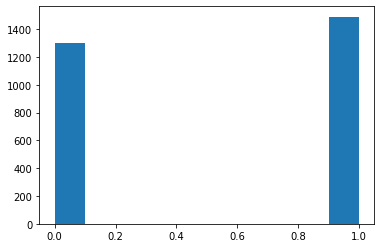

In [8]:
import matplotlib.pyplot as plt

plt.hist(labels)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.3, random_state=1)

In [10]:
len(X_train), len(X_test), len(y_train), len(y_test)

(1954, 838, 1954, 838)

In [11]:
from torch.utils.data import Dataset, DataLoader

class CrytoNewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y 

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [12]:
train_dataset = CrytoNewsDataset(X_train, y_train)
test_dataset = CrytoNewsDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [13]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1)

In [14]:
from transformers import get_scheduler

num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [15]:
class Average:
    def __init__(self):
        self.avg = 0
        self.size = 0
    
    def update(self, value, size):
        self.avg = (self.avg*self.size + value*size) / (self.size + size)
        self.size += size
    
    def item(self):
        return self.avg

In [16]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weight

array([1.06775956, 0.94032724])

In [17]:
from tqdm.auto import tqdm


progress_bar = tqdm(range(num_training_steps))
loss_func = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(weight), dtype=torch.float32, device=device))
model.train()
losses = []
accs = []
test_losses = []
test_accs = []

for epoch in range(num_epochs):
    loss_avg = Average()
    acc_avg = Average()
    model.train()
    for X,y in train_dataloader:
        X_token = tokenizer(X, return_tensors="pt", padding=True).to(device)
        y_pred = model(**X_token).logits
        loss = loss_func(y_pred, y.to(device))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        with torch.no_grad():
            acc = torch.sum(y_pred.argmax(axis=1) == y.to(device))
            loss_avg.update(loss.item(), len(y))
            acc_avg.update(acc.item()/len(y), len(y))

        progress_bar.update(1)
        progress_bar.set_description(f"Loss: {loss_avg.item():.3f}, Acc: {acc_avg.item():.3f}")
    
    test_loss_avg = Average()
    test_acc_avg = Average()
    model.eval()
    with torch.no_grad():
        for X,y in test_dataloader:
            X_token = tokenizer(X, return_tensors="pt", padding=True).to(device)
            y_pred = model(**X_token).logits
            loss = loss_func(y_pred, y.to(device))
            acc = torch.sum(y_pred.argmax(axis=1) == y.to(device))
            test_loss_avg.update(loss.item(), len(y))
            test_acc_avg.update(acc.item()/len(y), len(y))

    losses.append(loss_avg.item())
    accs.append(acc_avg.item())
    test_losses.append(test_loss_avg.item())
    test_accs.append(test_acc_avg.item())
    print(f"[EPOCH {epoch}] Loss: {loss_avg.item():.3f}, Acc: {acc_avg.item():.3f} Test Loss: {test_loss_avg.item():.3f}, Test Acc: {test_acc_avg.item():.3f}")

  0%|          | 0/155 [00:00<?, ?it/s]

[EPOCH 0] Loss: 0.813, Acc: 0.502 Test Loss: 0.699, Test Acc: 0.527
[EPOCH 1] Loss: 0.694, Acc: 0.520 Test Loss: 0.694, Test Acc: 0.520
[EPOCH 2] Loss: 0.687, Acc: 0.541 Test Loss: 0.695, Test Acc: 0.510
[EPOCH 3] Loss: 0.681, Acc: 0.563 Test Loss: 0.695, Test Acc: 0.525
[EPOCH 4] Loss: 0.681, Acc: 0.579 Test Loss: 0.695, Test Acc: 0.530


In [18]:
predictions = []
y_test = []

model.eval()
with torch.no_grad():
    for X,y in test_dataloader:
        X_token = tokenizer(X, return_tensors="pt", padding=True).to(device)
        y_pred = model(**X_token).logits
        predictions += list(y_pred.argmax(axis=1).cpu().numpy())
        y_test += list(y.cpu().numpy())

In [19]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
print(tn, fp, fn, tp)
score = accuracy_score(y_test,predictions)
print(score)
report = classification_report(y_test,predictions)
print(report)

154 233 161 290
0.5298329355608592
              precision    recall  f1-score   support

           0       0.49      0.40      0.44       387
           1       0.55      0.64      0.60       451

    accuracy                           0.53       838
   macro avg       0.52      0.52      0.52       838
weighted avg       0.52      0.53      0.52       838

